In [125]:
%matplotlib inline

import shutil
import os
from joblib import dump, load
import urllib3
import certifi
from Bio import SeqIO
import Bio
from glob import glob
import json
from IPython import display
import pandas as pd
import numpy as np
import networkx as nx
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns
import re

![HIV genome](https://upload.wikimedia.org/wikipedia/commons/c/c6/HIV-genome.png)

In [3]:
patients = ["p{}".format(i) for i in range(1,12)]
hiv_regions = ["V3", "PR", "psi", "vpr", "vpu", "p1", "p2", "p6", "p7", "p15", "p17", "RRE"]

![HIV genome details](https://res.mdpi.com/viruses/viruses-08-00248/article_deploy/html/images/viruses-08-00248-g002.png)

In [4]:
def download_hivevo_haplotype(patient, hiv_region, folder):
    
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',
                               ca_certs=certifi.where())
    
    api = "https://hiv.biozentrum.unibas.ch/api/data/haplotypes/"
    
    url = "/".join((api, patient, hiv_region))

    if not os.path.isdir(folder):
        os.mkdir(folder)

    file_name = folder + "_".join(("hivevo", patient, region)) + ".fasta"

    with http.request('GET', url, preload_content=False) as res, open(file_name, 'wb') as out_file:

        shutil.copyfileobj(res, out_file)
        
folder = "data/"
for patient in patients:
    for region in hiv_regions:
        download_hivevo_haplotype(patient, region, folder)

In [32]:
file_lst = glob(folder + "*V3.fasta")
file_lst

['data/hivevo_p7_V3.fasta',
 'data/hivevo_p11_V3.fasta',
 'data/hivevo_p8_V3.fasta',
 'data/hivevo_p3_V3.fasta',
 'data/hivevo_p1_V3.fasta',
 'data/hivevo_p6_V3.fasta',
 'data/hivevo_p2_V3.fasta',
 'data/hivevo_p9_V3.fasta',
 'data/hivevo_p10_V3.fasta',
 'data/hivevo_p5_V3.fasta',
 'data/hivevo_p4_V3.fasta']

In [33]:
tdf = pd.DataFrame()
for path in file_lst:
    with open(path, "r") as f:
        records = json.load(f)
    df = pd.DataFrame(records)
    df = df.drop("description", axis=1)
    df["patient"] = path.split("_")[1]
    tdf = pd.concat([tdf, df])

In [34]:
tdf.groupby("patient").agg({"days since infection" : ["min", np.median, "max", pd.Series.nunique],
                            "patient": ["size"]}).sort_index()

days since infection                      patient
                         min median   max nunique    size
patient                                                  
p1                       122   2639  2996      12     103
p10                       33   2229  2229       2      16
p11                      209   1026  2043       6      86
p2                        74    936  2018       5      11
p3                       146    797  3079       7      65
p4                        93   1142  3069       8      67
p5                       134   1813  2149       6      68
p6                        62   2556  2556       5      36
p7                      2369   3992  5869       8      97
p8                        87   1437  2208       7     133
p9                       106    813  2955       6      17

In [35]:
tdf.columns = ["days", "frequency", "name", "sequence", "patient"]

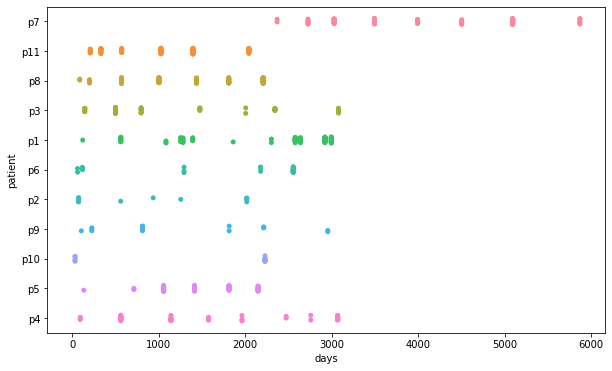

In [36]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
sns.stripplot(y="patient", x="days", data=tdf, )

I will remove p10, because there are too few time points and p7, because it's too different from other samples.

In [37]:
tdf = tdf[~tdf.patient.isin(["p7", "p10"])]
tdf.shape

(586, 5)

In [38]:
tdf.columns = ["days", "frequency", "name", "sequence", "patient"]

In [39]:
_, bin_edges = np.histogram(tdf.days.values, 5)
bin_edges[0] -= 1
bin_edges[-1] += 1
tdf["bins"] = np.digitize(tdf.days.values, bin_edges)
tdf.head()

,days,frequency,name,sequence,patient,bins
0,209,39.0,ACAGTATCAACTCAACTGCTGTTAAATGGCAGCCTAGCAGAAGAAG...,days_209_frequency_39%,p11,1
1,332,39.0,ACAGTATCAACTCAACTGCTGTTAAATGGCAGCCTAGCAGAAGAAG...,days_332_frequency_39%,p11,1
2,209,23.0,ACAGTATCAACTCAACTGCTGTTAAATGGCAGCCTAGCAGAAGAAG...,days_209_frequency_23%,p11,1
3,209,7.0,ACAGTATCAACTCAACTGCTGTTAAATGGCAGCCTAGCAGAAGAAG...,days_209_frequency_7%,p11,1
4,332,2.0,ACAGTATCAACTCAACTGCTGTTAAATGGCAGCCTAGCAGAAGAAG...,days_332_frequency_2%,p11,1


In [40]:
tdf.loc[tdf['patient'] == 'p3']

,days,frequency,name,sequence,patient,bins
0,146,24.0,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,days_146_frequency_24%,p3,1
1,146,3.0,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,days_146_frequency_3%,p3,1
2,146,11.0,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,days_146_frequency_11%,p3,1
3,146,21.0,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,days_146_frequency_21%,p3,1
4,146,18.0,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAG...,days_146_frequency_18%,p3,1
...,...,...,...,...,...,...
60,3079,15.0,GTAGTCTCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGGAG...,days_3079_frequency_15%,p3,5
61,3079,12.0,GTAGTCTCAACTCAACTGCTGTTAAATGGCAGTCTAGCAAAAGGAG...,days_3079_frequency_12%,p3,5
62,3079,21.0,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGGAG...,days_3079_frequency_21%,p3,5
63,3079,21.0,GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGGAG...,days_3079_frequency_21%,p3,5


In [41]:
tdf.groupby(["patient", "bins"]).size().unstack(fill_value=0)

bins,1,2,3,4,5
patient,,,,,
p1,10,7,10,2,74
p11,27,19,25,15,0
p2,5,2,0,4,0
p3,32,9,6,11,7
p4,21,13,5,6,22
p5,1,17,36,14,0
p6,6,0,3,3,24
p8,32,19,56,26,0
p9,4,6,2,3,2


In [125]:
tdf = tdf.drop("bins", axis=1)
# Will analyse everyone separately

In [67]:
re.search(r'\b[\w\/]+p4[\w\.]+\b', ' '.join(file_lst))[0]

'data/hivevo_p4_V3.fasta'

In [51]:
' '.join(file_lst)

'data/hivevo_p7_V3.fasta data/hivevo_p11_V3.fasta data/hivevo_p8_V3.fasta data/hivevo_p3_V3.fasta data/hivevo_p1_V3.fasta data/hivevo_p6_V3.fasta data/hivevo_p2_V3.fasta data/hivevo_p9_V3.fasta data/hivevo_p10_V3.fasta data/hivevo_p5_V3.fasta data/hivevo_p4_V3.fasta'

In [128]:
tdf[tdf.patient == "p4"].groupby('days').size()

days
93       3
562     18
1142    13
1577     5
1963     4
2474     2
2758     2
3069    20
dtype: int64

In [131]:
tdf = tdf.reset_index(drop=True)
tdf.loc[1, "sequence"]

'GTAGTATCAACTCAACTGCTGTTAAATGGCAGTCTAGCAGAAGAAGAGGTGGTCATTAGATCTGAAAATTTCACAAACAATGCTAAAACCATAATAGTACAGCTGAATGAAACTGTAGAAATTAATTGTACAAGACCCAATAACAATACAAGAAAGGGTATACATATAGGACCAGGGAGAGCATTTTATGCAACAGGAGAAATAATAGGAGATATAAGACAAGCACATTGTAACATTAGTAAAGCAAAATGGAATAACACTTTAGAAAAGATAGTTGAAAAACTAAGAGAACGATTTGAAAATAAAACAATATCCTTTAGGCCACCCTCAGGAGGGGACCTAGAAATTGTAACACACAGT'

In [73]:
!mkdir data/fasta

In [78]:
import json

path_json = 'data/hivevo_p4_V3.fasta'

with open(path_json) as f:
    json_file = json.load(f)
json_file[0]

{'days since infection': 93,
 'frequency [%]': 79.0,
 'sequence': 'GTAGTATCAACCCAACTGTTGTTAAATGGCAGCCTAGCAGAAGAAGGGGTAGTAGTTAGATCTGACAATTTCTCAAACAATGCTAAAACCATCATAGTACAGTTGCACAAAGCTGTAGAAATTAATTGCACAAGACCCAGCAACAATACAAGCAAAGGTATACATATGGGACCAGGGAAAGCATTTTATACAACAGAAAAAATAATAGGAGATATAAGACAAGCACATTGTAACATTAGTAAAGAGAAATGGAACGACACTTTAAGACAGATAGCTATAAAATTAAGAGCACAATTTCCGAGTAAAACAATAATCTTTGATAAATCCTCAGGAGGGGACCTAGAAATTGTAACACACAGT',
 'name': 'days_93_frequency_79%',
 'description': 'days_93_frequency_79% days since infection: 93, frequency: 79%, n.reads: 118'}

In [82]:
path = path_json.replace('data/', 'data/fasta/')   
with open(path, "w") as fasta_file:
    i = 0
    for obj in json_file:
        line_1 = '>' + obj['name'] + str(i) + '\n'
        line_2 = obj['sequence'] + '\n'
        lines = [line_1, line_2]
        fasta_file.writelines(lines)
        i += 1

In [103]:
from Bio.Align.Applications import ClustalwCommandline
clustalw_cline = ClustalwCommandline("clustalw",  align = 'True', infile="data/fasta/hivevo_p4_V3.fasta", output = 'FASTA', outfile = 'data/clustal_output/hivevo_p4_V3.fasta', type = 'DNA')
stdout, stderr = clustalw_cline()
#print(clustalw_cline)

In [107]:
# SHOULD BE USED https://biopython.org/DIST/docs/api/Bio.Phylo.Applications._Fasttree-module.html

!fasttree -nt -gtr < data/clustal_output/hivevo_p4_V3.fasta > data/trees/hivevo_p4_V3.nwk

FastTree Version 2.1.10 Double precision (No SSE3)
Alignment: standard input
Nucleotide distances: Jukes-Cantor Joins: balanced Support: SH-like 1000
Search: Normal +NNI +SPR (2 rounds range 10) +ML-NNI opt-each=1
TopHits: 1.00*sqrtN close=default refresh=0.80
ML Model: Generalized Time-Reversible, CAT approximation with 20 rate categories
Initial topology in 0.01 seconds
Refining topology: 24 rounds ME-NNIs, 2 rounds ME-SPRs, 12 rounds ML-NNIs
Total branch-length 0.735 after 0.09 sec
ML-NNI round 1: LogLk = -2329.742 NNIs 14 max delta 7.57 Time 0.14
GTR Frequencies: 0.4336 0.1584 0.1892 0.2188ep 7 of 12   
GTR rates(ac ag at cg ct gt) 2.5541 10.8881 0.5893 1.1855 11.6602 1.0000
Switched to using 20 rate categories (CAT approximation)13 of 20   
Rate categories were divided by 0.767 so that average rate = 1.0
CAT-based log-likelihoods may not be comparable across runs
Use -gamma for approximate but comparable Gamma(20) log-likelihoods
ML-NNI round 2: LogLk = -1962.601 NNIs 9 max delta 

In [114]:
from Bio import Phylo

tree = Phylo.read('data/trees/hivevo_p4_V3.nwk', 'newick')

In [122]:
graph = Phylo.to_networkx(tree)

In [136]:
tree.total_branch_length()

1.0677722899999997

In [130]:
def clade_names_fix(tree):
    for idx, clade in enumerate(tree.find_clades()):
        if not clade.name:
            clade.name=str(idx)

Tree = Phylo.read('data/trees/hivevo_p4_V3.nwk', 'newick')
clade_names_fix(Tree)
G = Phylo.to_networkx(Tree)

In [132]:
#nx.algorithms.all_simple_paths(G, )
G.edges

EdgeView([(Clade(name='0'), Clade(branch_length=0.003607269, name='days_562_frequency_2%9')), (Clade(name='0'), Clade(branch_length=0.003608928, name='days_562_frequency_3%11')), (Clade(name='0'), Clade(branch_length=5e-09, confidence=0.867, name='3')), (Clade(branch_length=5e-09, confidence=0.867, name='3'), Clade(branch_length=5e-09, name='days_562_frequency_10%10')), (Clade(branch_length=5e-09, confidence=0.867, name='3'), Clade(branch_length=5e-09, confidence=0.884, name='5')), (Clade(branch_length=5e-09, confidence=0.884, name='5'), Clade(branch_length=0.003628687, confidence=0.875, name='6')), (Clade(branch_length=5e-09, confidence=0.884, name='5'), Clade(branch_length=0.003595639, confidence=0.775, name='115')), (Clade(branch_length=0.003628687, confidence=0.875, name='6'), Clade(branch_length=0.003678204, confidence=0.809, name='7')), (Clade(branch_length=0.003628687, confidence=0.875, name='6'), Clade(branch_length=6e-09, confidence=0.756, name='10')), (Clade(branch_length=0.0

In [137]:
### TODO: разобраться с графом,  найти самый длинный путь и посмотреть гидрофобность